Files already downloaded and verified
Average client model version: 0.0
Round 1, Global Loss: 0.046111081767082215, Global Accuracy: 0.0667
Average client model version: 0.0
Round 2, Global Loss: 0.04613826315402984, Global Accuracy: 0.064
Average client model version: 0.0
Round 3, Global Loss: 0.04618212382793427, Global Accuracy: 0.0647
Average client model version: 0.0
Round 4, Global Loss: 0.046255104422569276, Global Accuracy: 0.0668
Average client model version: 0.0
Round 5, Global Loss: 0.04638018515110016, Global Accuracy: 0.0694
Average client model version: 0.0
Round 6, Global Loss: 0.04659953622817993, Global Accuracy: 0.0736
Average client model version: 0.0
Round 7, Global Loss: 0.04697026934623718, Global Accuracy: 0.0779
Average client model version: 0.0
Round 8, Global Loss: 0.04752758793830872, Global Accuracy: 0.0825
Average client model version: 0.45
Round 9, Global Loss: 0.048350015115737915, Global Accuracy: 0.0949
Average client model version: 0.87
Round 10, Globa

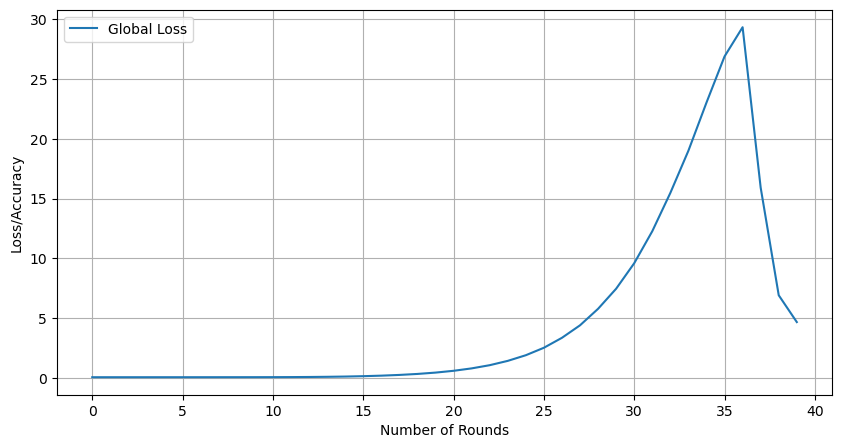

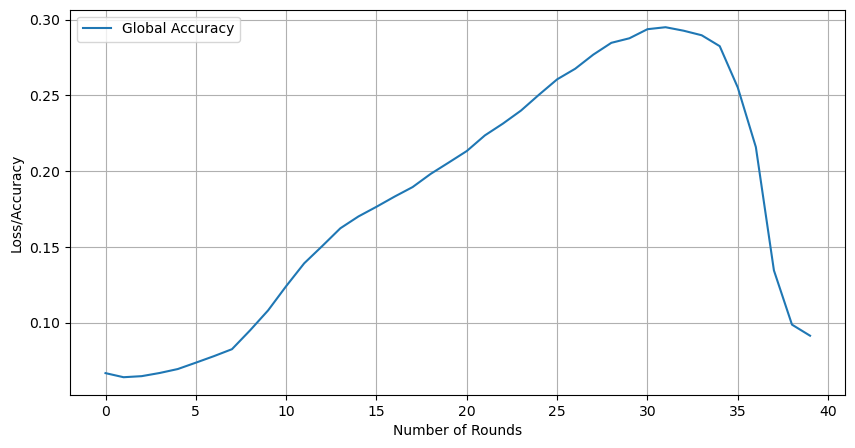

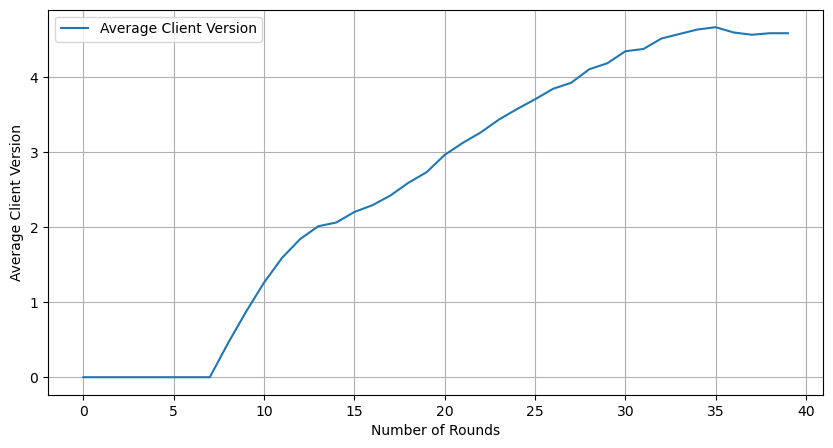

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

num_clients = 100
num_selected = 10
num_rounds = 40
local_epochs = 2
batch_size = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1)
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        self.fc1 = nn.Linear(4*4*64, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CIFAR_CNN(nn.Module):
    def __init__(self):
        super(CIFAR_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, 1)
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        self.fc1 = nn.Linear(5*5*64, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 5*5*64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

global_model = CIFAR_CNN().to(device)
client_models = [CIFAR_CNN().to(device) for _ in range(num_clients)]
clients = [i for i in range(num_clients)]
for model in client_models:
    model.load_state_dict(global_model.state_dict())

criterion = nn.CrossEntropyLoss()

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = datasets.CIFAR10('../data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('../data', train=False, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

non_iid_train_data = [[] for _ in range(num_clients)]
num_shards = 200
shard_size = 250
shards = [i for i in range(num_shards)]
client_versions = np.zeros(dtype=int, shape=(num_clients,))

opt = [optim.SGD(model.parameters(), lr=0.00012) for model in client_models]

# # Split the data into non-iid shards
# for i in range(num_clients):
#     random.shuffle(shards)
#     for j in range(num_shards):
#         shard = shards[j]
#         indices = np.random.choice(shard_size, 10, replace=False)
#         for idx in indices:
#             non_iid_train_data[i].append(shard * shard_size + idx)

def non_iid_cifar10(num_clients, num_shards, shard_size, train_dataset):
    non_iid_train_data = [[] for _ in range(num_clients)]
    shards = [i for i in range(num_shards)]
    for i in range(num_clients):
        random.shuffle(shards)
        for j in range(num_shards):
            shard = shards[j]
            indices = np.random.choice(shard_size, 10, replace=False)
            for idx in indices:
                non_iid_train_data[i].append(shard * shard_size + idx)
    return non_iid_train_data

non_iid_train_data = non_iid_cifar10(num_clients, num_shards, shard_size, train_dataset)
client_dataloaders = [DataLoader(train_dataset, batch_size=batch_size, sampler=non_iid_train_data[i], drop_last=True) for i in range(num_clients)]

def manhattan_norm(client_model, global_model):
    client_weights = client_model.state_dict()
    global_weights = global_model.state_dict()
    for key in client_weights.keys():
        norm = torch.norm(client_weights[key] - global_weights[key], p=1)
        norm = norm.item()
    return norm

def VAoI(client_versions, client_models, global_model, num_selected, clients):
    threshold = 0.19
    h = np.exp(client_versions)
    probabilities = h / np.sum(h)

    selected_clients = np.random.choice(clients, num_selected, replace=False, p=probabilities)

    for client in clients:
        client_norm = manhattan_norm(client_models[client], global_model)
        if client_norm >= threshold:
            client_versions[client] += 1.0
        if client in selected_clients:
            client_versions[client] = 0.0
        else :
            client_versions[client] = client_versions[client]
    return selected_clients, client_versions

def train_client(client_model, client_dataloader, optimizer):
    client_model.train()
    criterion = nn.CrossEntropyLoss()
    for epoch in range(local_epochs):
        for data, target in client_dataloader: 
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = client_model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    return client_model

def update_global_model(global_model, client_models, selected_clients):
    for client in selected_clients:
        global_model_weights = global_model.state_dict()
        client_model_weights = client_models[client].state_dict()
        for key in global_model_weights.keys():
            global_model_weights[key] += client_model_weights[key]
        global_model.load_state_dict(global_model_weights)

    for key in global_model.state_dict().keys():
        global_model.state_dict()[key] /= len(selected_clients)

    return global_model

def distribute_data_dirichlet(data, labels, num_clients, percent_class_imbalance):
    # Get the total number of samples and the number of classes
    num_samples = len(data)
    num_classes = len(np.unique(labels))

    # Generate a distribution of samples for each client
    client_probs = np.random.dirichlet([percent_class_imbalance] * num_clients)

    # Split the data into a list of dataframes for each client
    client_data = []
    client_labels = []
    for i in range(num_clients):
        # Calculate the number of samples for this client
        num_samples_client = int(client_probs[i] * num_samples)

        # Sample from each class according to the client's probability
        client_data_i = []
        client_labels_i = []
        for c in range(num_classes):
            data_c = data[labels == c]
            labels_c = labels[labels == c]
            data_c_client, _, labels_c_client, _ = train_test_split(data_c, labels_c, train_size=num_samples_client)
            client_data_i.append(data_c_client)
            client_labels_i.append(labels_c_client)

        # Concatenate the data and labels for this client
        client_data.append(np.concatenate(client_data_i))
        client_labels.append(np.concatenate(client_labels_i))

    return client_data, client_labels

def FedAvg(num_rounds, num_selected, client_models, global_model, client_dataloaders, clients, opt, test_loader, client_versions):
    global_losses = []
    global_accuracies = []
    average_client_version = []
    for i in range(num_rounds):
        selected_clients, client_versions = VAoI(client_versions, client_models, global_model, num_selected, clients)
        average_client_version.append(np.mean(client_versions))
        print(f"Average client model version: {np.mean(client_versions)}")
        for client in selected_clients:
            client_dataloader = client_dataloaders[client]
            client_model = client_models[client]
            client_model.load_state_dict(global_model.state_dict())
            client_optimizer = opt[client]
            client_model = train_client(client_model,client_dataloader, client_optimizer)
            client_models[client] = client_model
        global_model = update_global_model(global_model, client_models, selected_clients)
        global_loss, global_accuracy = test_global_model(global_model, test_loader)
        print(f"Round {i+1}, Global Loss: {global_loss}, Global Accuracy: {global_accuracy}")
        global_losses.append(global_loss)
        global_accuracies.append(global_accuracy)
    return global_model, global_losses, global_accuracies, average_client_version

def test_global_model(global_model, test_loader):
    global_model.eval()
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = global_model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    return test_loss, accuracy

global_model_mnist, global_losses_1, global_accuracies_1, average_client_version1 = FedAvg(num_rounds, 
                                                                  num_selected, 
                                                                  client_models, 
                                                                  global_model, 
                                                                  client_dataloaders, 
                                                                  clients, 
                                                                  opt, 
                                                                  test_loader, 
                                                                  client_versions)

plt.figure(figsize=(10, 5))
plt.plot(global_losses_1, label='Global Loss')
plt.xlabel('Number of Rounds')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(global_accuracies_1, label='Global Accuracy')
plt.xlabel('Number of Rounds')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(average_client_version1, label='Average Client Version')
plt.xlabel('Number of Rounds')
plt.ylabel('Average Client Version')
plt.legend()
plt.grid(True)
plt.show()